In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))



In [2]:
#read the file
df = pd.read_csv('Data Extraction/KNCUSDT-1h-binance.csv')

In [3]:
df['Date'] = df['timestamp']

In [4]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'close'])

#creating dataframe with date and the target variable
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['close'][i] = data['close'][i]

# splitting into train and validation
train = new_data[:10000]
valid = new_data[10000:]


In [5]:
len(valid)

2500

In [6]:
# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['close'][len(train)-2500+i:].sum() + sum(preds)
    b = a/2500
    preds.append(b)


In [7]:

# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['close'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
0.2165350948028594


In [8]:
#Linear Regression
from fastai.tabular.all import *
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp





In [9]:
train = new_data[:10000]
valid = new_data[10000:]
x_train = train.drop('close', axis=1)
y_train = train['close']
x_valid = valid.drop('close', axis=1)
y_valid = valid['close']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [10]:
preds = model.predict(x_valid)
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

0.38842573570205274

In [11]:
#importing libraries
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [12]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

In [13]:
#rmse
rms=np.sqrt(np.mean(np.power((np.array(y_valid)-np.array(preds)),2)))
rms

0.6515432542817091

In [14]:
from pmdarima.arima import auto_arima

data = df.sort_index(ascending=True, axis=0)

train = data[:10000]
valid = data[10000:]

training = train['close']
validation = valid['close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

forecast = model.predict(n_periods=2500)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=15.73 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-32882.899, Time=0.66 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-35405.068, Time=2.34 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=12.56 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-32899.251, Time=0.36 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-36610.583, Time=12.85 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=44.53 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=21.47 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-36586.639, Time=4.78 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-36631.570, Time=6.96 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-35429.438, Time=3.04 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=67.71 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=20.99 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-36629.582, Time=15.72 sec
 ARIMA(2,1,1)(2,1,0)[12] 

In [15]:
rms=np.sqrt(np.mean(np.power((np.array(valid['close'])-np.array(forecast['Prediction'])),2)))
rms

3.1875615448191255

In [25]:
new_data

KeyError: (100, 0)

from fbprophet import Prophet

#creating dataframe
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['close'][i] = data['close'][i]

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'close': 'y', 'Date': 'ds'}, inplace=True)

#train and validation
train = new_data[:10000]
valid = new_data[10000:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

In [99]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['close'][i] = data['close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:10000,:]
valid = dataset[10000:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    print(x_train[-1][-1]-y_train[-1])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

0.0012019230769230727
0.0036057692307692735
0.004807692307692291
0.006911057692307654
-0.0093149038461538
0.011418269230769218
0.004807692307692346
0.004507211538461509
-0.004507211538461509
0.016826923076923017
-0.005108173076923073
-0.010216346153846145
0.0012019230769230727
0.006310096153846145
0.009615384615384581
-0.010216346153846145
-0.002704326923076872
-0.0015024038461537992
-0.005709134615384692
-0.010216346153846145
0.0030048076923077094
-0.00030048076923078204
0.006310096153846145
-0.007211538461538436
0.0027043269230769273
0.0009014423076922906
0.0027043269230769273
-0.0015024038461538547
0.004807692307692291
-0.00631009615384609
-0.0009014423076923461
-0.008413461538461564
0.0012019230769230727
-0.002704326923076872
0.0009014423076922906
0.0033052884615384914
0.0006009615384615086
-0.0027043269230769273
0.0021033653846154188
-0.0018028846153846367
-0.0018028846153846367
-0.018028846153846145
0.015625
-0.006310096153846201
0.002704326923076983
-0.0018028846153846367
-0.000

0.0006009615384615086
-0.0012019230769230727
0.0036057692307692735
-0.0030048076923077094
0.00390625
0.0009014423076922906
0.0006009615384615641
0.0009014423076922906
0.0
-0.0009014423076922906
0.0
-0.0018028846153846367
0.0012019230769230727
0.0018028846153846367
-0.00030048076923078204
0.00030048076923078204
-0.004206730769230782
0.0012019230769230727
-0.00030048076923078204
0.0
0.0006009615384615641
-0.0006009615384615641
0.007211538461538491
-0.0009014423076922906
0.00030048076923072653
-0.00030048076923072653
-0.0012019230769231282
-0.0015024038461537992
0.00030048076923072653
0.0009014423076923461
-0.0006009615384615641
0.0024038461538461453
-0.00030048076923072653
-0.0009014423076923461
0.0021033653846154188
-0.0015024038461538547
0.0042067307692307265
0.00390625
-0.0009014423076922906
0.0006009615384615086
0.0
-0.003305288461538436
0.0009014423076922906
0.0027043269230769273
0.0030048076923077094
-0.00390625
0.0027043269230769273
0.0006009615384615086
0.00390625
-0.003004807692

0.015625000000000056
-0.005408653846153855
0.009915865384615363
-0.005408653846153855
-0.0030048076923077094
-0.002704326923076872
-0.007512019230769218
0.00030048076923072653
0.00390625
0.006310096153846145
0.007812500000000056
0.0024038461538461453
0.006911057692307654
0.012920673076923128
-0.00030048076923083755
0.0018028846153846367
-0.0009014423076922906
-0.00030048076923078204
-0.016225961538461564
-0.009915865384615363
-0.0033052884615384914
0.005408653846153855
-0.015324519230769218
-0.0093149038461538
0.010216346153846145
-0.005709134615384637
0.0024038461538461453
-0.004807692307692291
0.004807692307692291
0.006310096153846145
0.0033052884615384914
-0.009615384615384637
0.002704326923076983
-0.0075120192307692735
-0.002704326923076872
-0.008112980769230838
-0.0036057692307692735
0.013822115384615419
0.00030048076923078204
0.0006009615384615641
-0.012620192307692346
-0.0015024038461538547
0.008112980769230838
0.0021033653846153078
0.017127403846153855
0.0
-0.006310096153846145

9940/9940 - 108s - loss: 5.0182e-04 - 108s/epoch - 11ms/step


In [100]:
#predicting 2500 values, using past 60 from the train data
inputs = new_data.iloc[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [101]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

0.03683066685377503

Text(0.5, 0, '')

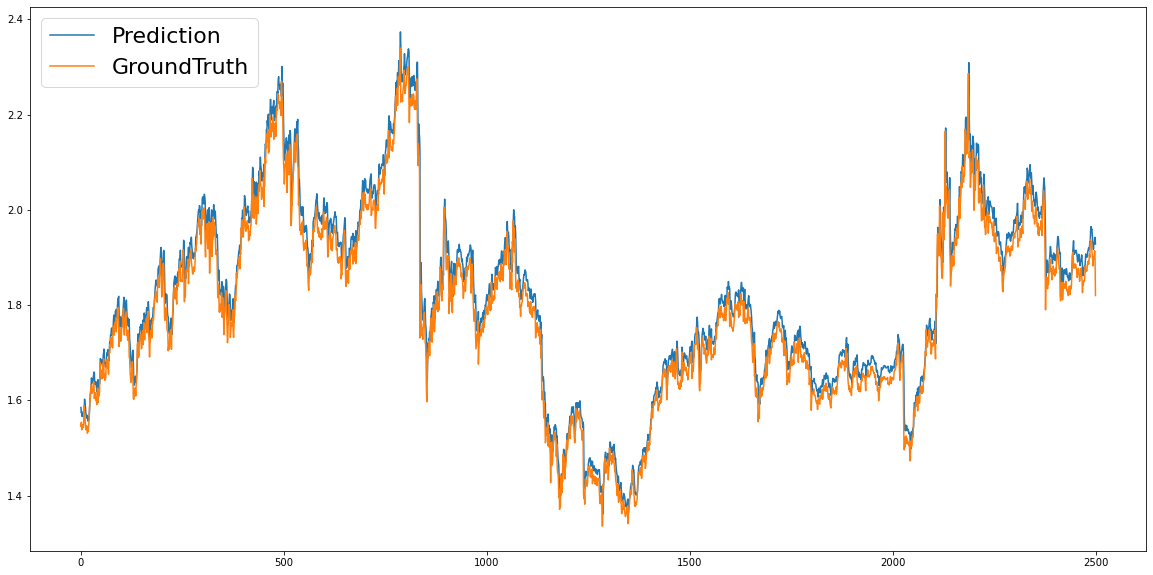

In [102]:
plt.plot(closing_price,label='Prediction')
plt.plot(valid,label='GroundTruth')
plt.legend(fontsize = 22)
plt.xlabel('')

In [103]:
dff = pd.DataFrame(closing_price)  

In [104]:
dff['closing_price'] = closing_price

In [105]:
dff['valid'] = dff[0]
dff

,0,closing_price,valid
0,1.584938,1.584938,1.584938
1,1.573627,1.573627,1.573627
2,1.576607,1.576607,1.576607
3,1.565959,1.565959,1.565959
4,1.570638,1.570638,1.570638
...,...,...,...
2495,1.931023,1.931023,1.931023
2496,1.928714,1.928714,1.928714
2497,1.932736,1.932736,1.932736
2498,1.942271,1.942271,1.942271


In [106]:
Has_KNC = False
pnl = []
pnl.append(1000)
money = 1000
for k in range(1,len(dff)):
    if dff.iloc[k]['closing_price'] > dff.iloc[k-1]['valid'] and not Has_KNC:
        share = money/dff.iloc[k-1]['valid']
        Has_KNC = True
        
    if dff.iloc[k]['closing_price'] < dff.iloc[k-1]['valid'] and Has_KNC:
        money = share* dff.iloc[k-1]['valid']
        Has_KNC = False
    if Has_KNC:
        pnl.append(share * dff.iloc[k-1]['valid'])
    else:
        pnl.append(money)

        


In [107]:
pnl[-1]

5594571.657126068

1